### part0:imports

In [100]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection
from collections import Counter
import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        defs = params.random_walk_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'random_walk')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

import warnings
warnings.filterwarnings("ignore")

Done


### Get data

In [132]:
def get_full_random_walk_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList['MCx'].items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    allDFs_exec_MCx = []
    for animal, session in full_list_MCx:
        path = root/'random_walk'/animal/session
        df_ = defs.prep_general(dt.load_pyal_data(path))

        #separate into reaches
        df_ = defs.get_reaches_df(df_)
        df_['reach_id'] = range(len(df_))

        #subset center-out trials
        df_ = df_[df_.center_dist < defs.subset_radius]
        df_ = df_.reset_index()

        #execution epoch
        for col in df_.columns:  #TODO: placeholder to prevent bug in pyaldata
            if 'unit_guide' in col:
                df_ = df_.drop([col], axis = 1)
        df_ = pyal.add_movement_onset(df_)
        allDFs_MCx.append(df_)

        df_ = pyal.restrict_to_interval(df_, epoch_fun=defs.exec_epoch)
        allDFs_exec_MCx.append(df_)

        # print(len(df_))
        
    return full_list_MCx, allDFs_MCx, allDFs_exec_MCx

In [133]:
MCx_list, allDFs_MCx, allDFs_exec_MCx = get_full_random_walk_data()

In [139]:
import random_walk.defs as defs
reload(defs)

ref_file = 'Chewie_RT_CS_2016-10-21.mat'
ref_i = [y for x,y in MCx_list].index(ref_file)

ex_file = 'Mihili_RT_VR_2014-01-15.mat'
ex_i = [y for x,y in MCx_list].index(ex_file)

df1 = allDFs_exec_MCx[ref_i]
df2 = allDFs_exec_MCx[ex_i]

#### Get paired dfs

In [140]:
ref_file = 'Chewie_RT_CS_2016-10-21.mat'
ref_i = [y for x,y in MCx_list].index(ref_file)
df1 = allDFs_exec_MCx[ref_i]

Mihili_files = GoodDataList['MCx']['Mihili']
# MrT_files = GoodDataList['MCx']['MrT']

paired_dfs = []
for ex_file in Mihili_files:
    print(ex_file)
    # ex_file = 'Mihili_RT_VR_2014-01-15.mat'
    ex_i = [y for x,y in MCx_list].index(ex_file)
    df2 = allDFs_exec_MCx[ex_i]

    #subset dataframes with matched reaches
    df1_idx, df2_idx = defs.get_matched_reaches_idx(df1, df2)
    df1_subset = df1.iloc[df1_idx]
    df2_subset = df2.iloc[df2_idx]

    #get dataframes from whole-trial data
    df1_ = pd.DataFrame({'reach_id':df1_subset.reach_id}).merge(allDFs_MCx[ref_i])
    df2_ = pd.DataFrame({'reach_id':df2_subset.reach_id}).merge(allDFs_MCx[ex_i])

    #set target ids
    # print(len(df1_) - (df1_.target_group.values == df2_.target_group.values).sum(), 'diff target groups')
    df1_.target_group = df2_.target_group.values 
    df1_['target_id'] = df1_.target_group.values
    df2_['target_id'] = df2_.target_group.values

    #only keep target groups with enough trials
    counter = Counter(df1_.target_group)
    subset_target_groups = [k for k, c in counter.items() if c >= defs.min_trials_per_target]
    df1_ = df1_[df1_.target_group.isin(subset_target_groups)]
    df2_ = df2_[df2_.target_group.isin(subset_target_groups)]
    print(len(subset_target_groups))

    paired_dfs.append((ex_file, df1_, df2_))
    

Mihili_RT_FF_2014-02-14.mat
21
Mihili_RT_FF_2014-02-21.mat
20
Mihili_RT_FF_2014-02-24.mat
23
Mihili_RT_VR_2014-01-14.mat
23
Mihili_RT_VR_2014-01-16.mat
19
Mihili_RT_VR_2014-01-15.mat
26


#### Perform CCA

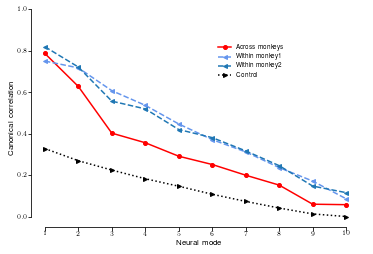

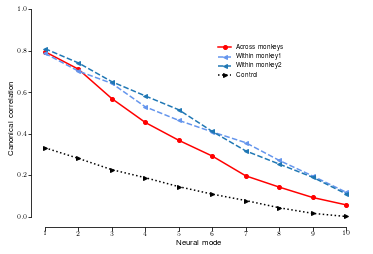

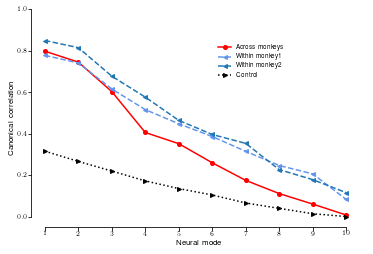

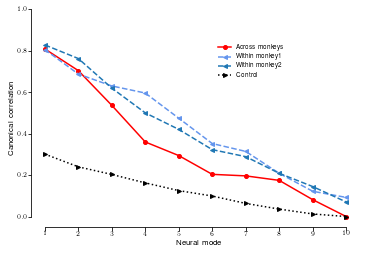

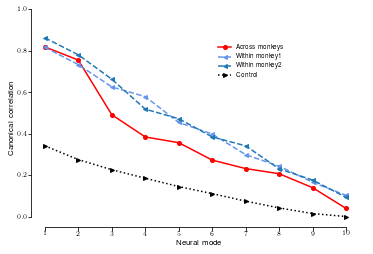

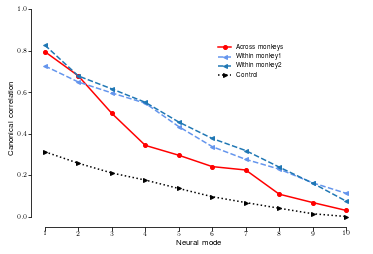

In [141]:
for ex_file, df1_, df2_ in paired_dfs:
    subset_target_groups = np.unique(df1_.target_group)

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #session x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
        
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
        
    # upper bound
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate([AllData1[0], AllData2[0]]):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    fig, ax = plt.subplots()
    x_ = np.arange(1,defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])

    info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target)])
    plt.savefig("figures/cca_"+info+'.pdf', format= 'pdf')

In [124]:
# for ex_file, df1_, df2_ in paired_dfs:
#     subset_target_groups = np.unique(df1_.target_group)

#     #perform cca ################################################
#     AllData1 = defs.get_data_array(df1_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
#     AllData2 = defs.get_data_array(df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
#     # print(AllData1.shape) #session x target_groups x trials x time x modes
#     _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
#     allCCs=[]
#     for sessionData1,sessionData2 in zip(AllData1,AllData2):
#         data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
#         data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
#         allCCs.append(dt.canoncorr(data1, data2))
#     allCCs = np.array(allCCs).T
        
#     # lower bound
#     len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
#     AllDataL1 = defs._get_data_array(df1_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
#     AllDataL2 = defs._get_data_array(df2_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
#     _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
#     CCsL=[]
#     for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
#         r = []
#         for n in range(params.n_iter * 10):
#             sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
#             sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
#             data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
#             data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
#             r.append(dt.canoncorr(data1, data2))
#         CCsL.append(r)
#     CCsL = np.array(CCsL)
#     CCsL = np.percentile(CCsL, 1, axis=1).T
        
#     # upper bound
#     n_shared_trial1 = AllData1.shape[2]
#     trialList1 = np.arange(n_shared_trial1)
#     CCsU=[]
#     for session, sessionData in enumerate([AllData1[0], AllData2[0]]):
#         r = []
#         for n in range(params.n_iter * 10):
#             params.rng.shuffle(trialList1)
#             # non-overlapping randomised trials
#             trial1 = trialList1[:n_shared_trial1//2]
#             trial2 = trialList1[-(n_shared_trial1//2):]
#             data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
#             data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
#             r.append(dt.canoncorr(data1, data2))
#         CCsU.append(r)
#     CCsU = np.array(CCsU)
#     CCsU = np.percentile(CCsU, 99, axis=1).T

#     # plotting
#     fig, ax = plt.subplots()
#     x_ = np.arange(1,defs.n_components+1)
#     ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
#     ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
#     ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
#     ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')

#     ax.set_ylim([-.05,1])
#     ax.set_xlim([.6,defs.n_components+.6])
#     ax.set_xlabel('Neural mode')
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#     # ax.set_title(f'{defs.areas[2]} Alignment')
#     ax.legend(loc=(.55,.67))
#     ax.set_ylabel('Canonical correlation')

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_bounds([1,defs.n_components])
#     ax.spines['left'].set_bounds([0,1])

#     info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target)])
#     plt.savefig("figures/cca_"+info+'.pdf', format= 'pdf')

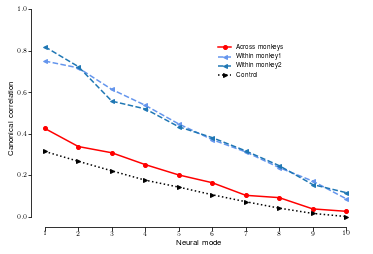

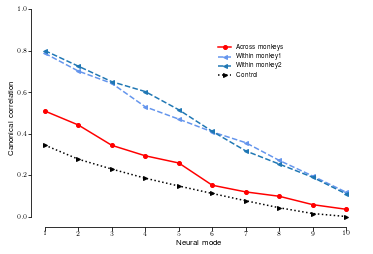

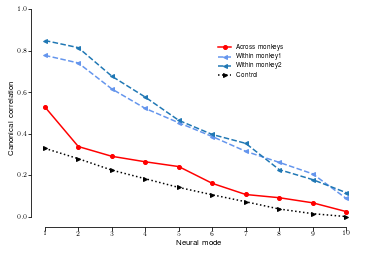

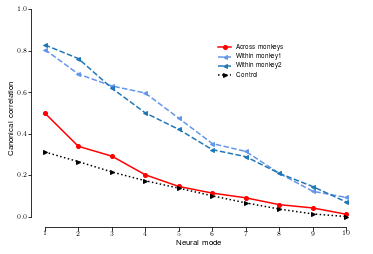

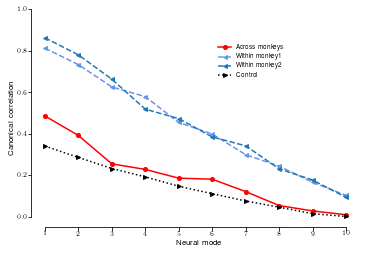

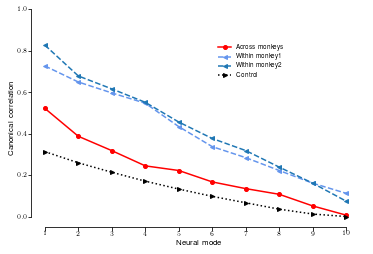

In [142]:
#test controls with shuffled targets
for ex_file, df1_, df2_ in paired_dfs:
    # df1_ = df1_.sample(frac = 1).reset_index() #shuffle rows
    # df1_.target_id = np.random.permutation(df1_.target_id.values) #shuffle all targets: lowers
    subset_target_groups = np.unique(df1_.target_group)
    
    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    shuffled_idx = np.random.permutation(np.arange(AllData1.shape[1])) #permutate targets: lowers
    AllData1[:] = AllData1[:,shuffled_idx,:,:,:]

    # print(AllData1.shape) #session x target_groups x trials x time x modes

    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
        
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
        
    # upper bound
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate([AllData1[0], AllData2[0]]):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    fig, ax = plt.subplots()
    x_ = np.arange(1,defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])

    # info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target)])
    # plt.savefig("figures/cca_"+info+'.pdf', format= 'pdf')

#### Behavioural correlation

In [143]:
@utility.report
def plot_monkey_cca_corr(paired_dfs):

    across_corrs_monkeys = defs.trim_across_monkey_corr(paired_dfs)
    CC_corr_monkey=[]

    # min_target_groups = np.inf
    # for _,df1_,_ in paired_dfs:
    #     n_groups = len(np.unique(df1.target_group))
    #     min_target_groups = np.min(min_target_groups, n_groups)

    #for each pair of sessions across monkeys
    for i, (_,df1_,df2_) in enumerate(paired_dfs):
        #get data for neural modes
        AllData1_monkey,AllData2_monkey = defs.get_paired_data_arrays(df1_, df2_, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
        # AllData2_monkey = defs.get_data_array(df2_, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
        _,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

        data1 = np.reshape(AllData1_monkey[:,:min_trials_monkey,:min_time_monkey,:], (-1,defs.n_components))
        data2 = np.reshape(AllData2_monkey[:,:min_trials_monkey,:min_time_monkey,:], (-1,defs.n_components))

        #get behavioral correlation
        behav = np.array(across_corrs_monkeys[i])
        # behav = behav[behav>params.Behav_corr_TH]

        #perform CCA
        CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
    CC_corr_monkey = np.array(CC_corr_monkey)
    
    #plotting
    fig, ax = plt.subplots()
    ax.scatter(CC_corr_monkey[:,1],CC_corr_monkey[:,0], color=params.colors.MonkeyPts, label='Monkeys', zorder=0)
    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    ax.set_ylim([.53,.85])
    ax.spines['left'].set_bounds([.55,.85])
    ax.set_xlim([.69,.95])
    ax.spines['bottom'].set_bounds([.7,.95])
    ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    return CC_corr_monkey[:,1], CC_corr_monkey[:,0]

In [130]:
import random_walk.defs as defs
reload(defs)



<module 'random_walk.defs' from '/home/jcc319/multi_animal_alignment/random_walk/defs.py'>

Executed: `plot_monkey_cca_corr` in 2.7s


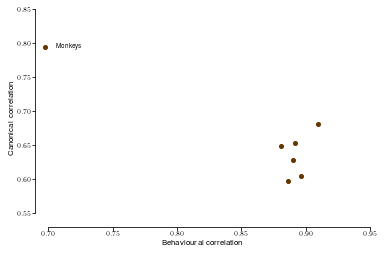

In [145]:
plot_monkey_cca_corr(paired_dfs);

<Figure size 432x288 with 0 Axes>

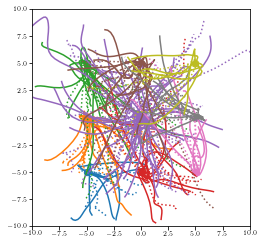

In [8]:
for ex_file, df1_, df2_ in paired_dfs[1:2]:
    #plot matched reaches
    plt.figure()
    ntrials = 10
    colors = utility.get_colors(defs.n_centers, 'tab10')
    target_groups = defs.target_groups
    plt.figure()
    df = df1_

    subset_target_groups = np.unique(df1_.target_group)

    center_ids = []
    for tar in subset_target_groups[:]:
        df1__ = df1_[df1_.target_group == tar]
        df2__ = df2_[df2_.target_group == tar]

        center_id = df2__.center_id.values[0]
        # if center_id in center_ids: continue

        center_ids.append(center_id)
        center = df2__.center.values[0]
        plt.scatter(center[0], center[1], s = 40, c= colors[center_id])

        for i in range(6):
            pos = df1__.pos_centered.values[i]
            # targets = df1__.target_centered.values[i]

            plt.plot(*pos[:].T, c=colors[center_id])
            # plt.scatter(*targets[:].T, s = 10, c=colors[center_id])

            pos = df2__.pos_centered.values[i]
            # targets = df2__.target_centered.values[i]
            plt.plot(*pos[:].T, c=colors[center_id], linestyle = 'dotted')
            # plt.scatter(*targets[:].T, s = 10, c=colors[color_idx],marker = '^')
    plt.gca().set_aspect(1)
    plt.xlim([-10,10])
    plt.ylim([-10,10])